## Classification Modeling: analyzing customer churn within Telco
### Goals

My main goal for this project is to construct a classification model that effectively predicts customer churn for Telco. I will be identifying which variables are the main drivers of churn, excluding contract type. 

I will be acquiring the data, cleaning and prepping it, give my predicitions and finally, my report and recommendations.

### Prepare Environment

In [1]:
# Overall Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pydataset import data

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Get and scrub the data
import acquire, prepare_2

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

# Save and load machine learning models
#import pickle, joblib

# Set plotting paras
plt.style.use('seaborn-talk')

### Data Acquisition

In [2]:
# Load dataset into pandas dataframe

df = acquire.get_telco_data()
print("Number of (rows, columns): ", df.shape)
df.head()

Number of (rows, columns):  (7043, 24)


,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


### Data Preparation

#### Summary of the data

In [3]:
# Print the summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
df.rename(columns = {'internet_service_type':'internet_service', 'NaN':'No_internet'}, inplace=True)

In [5]:
# Replace the white space with 0 in column total_charges
df['total_charges'] = df.total_charges.apply(lambda i: "0" if i == " " else i)

# Correct the data types of column total_charges 

datatype = {'total_charges': 'float64'}
df = df.astype(dtype=datatype)

df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges               float64
churn                        object
contract_type                object
internet_service             object
payment_type                 object
dtype: object

In [6]:
# Count distinct observations in each column
df.nunique()

payment_type_id                4
internet_service_type_id       3
contract_type_id               3
customer_id                 7043
gender                         2
senior_citizen                 2
partner                        2
dependents                     2
tenure                        73
phone_service                  2
multiple_lines                 3
online_security                3
online_backup                  3
device_protection              3
tech_support                   3
streaming_tv                   3
streaming_movies               3
paperless_billing              2
monthly_charges             1585
total_charges               6531
churn                          2
contract_type                  3
internet_service               3
payment_type                   4
dtype: int64

In [7]:
# Compute descriptive statistics of the numeric columns in the dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.00,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.00,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.00,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


### Plot Distribution of Individual Variables

In [8]:
# Obtain the name of the variables

variables = df.columns
print(len(variables))
print(type(variables))
variables

24
<class 'pandas.core.indexes.base.Index'>


Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service',
       'payment_type'],
      dtype='object')

In [9]:
# Obtain the name of the object columns

mask = (df.dtypes == 'object')
obj_cols = variables[mask].to_list()

print(len(obj_cols))
obj_cols

17


['customer_id',
 'gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service',
 'payment_type']

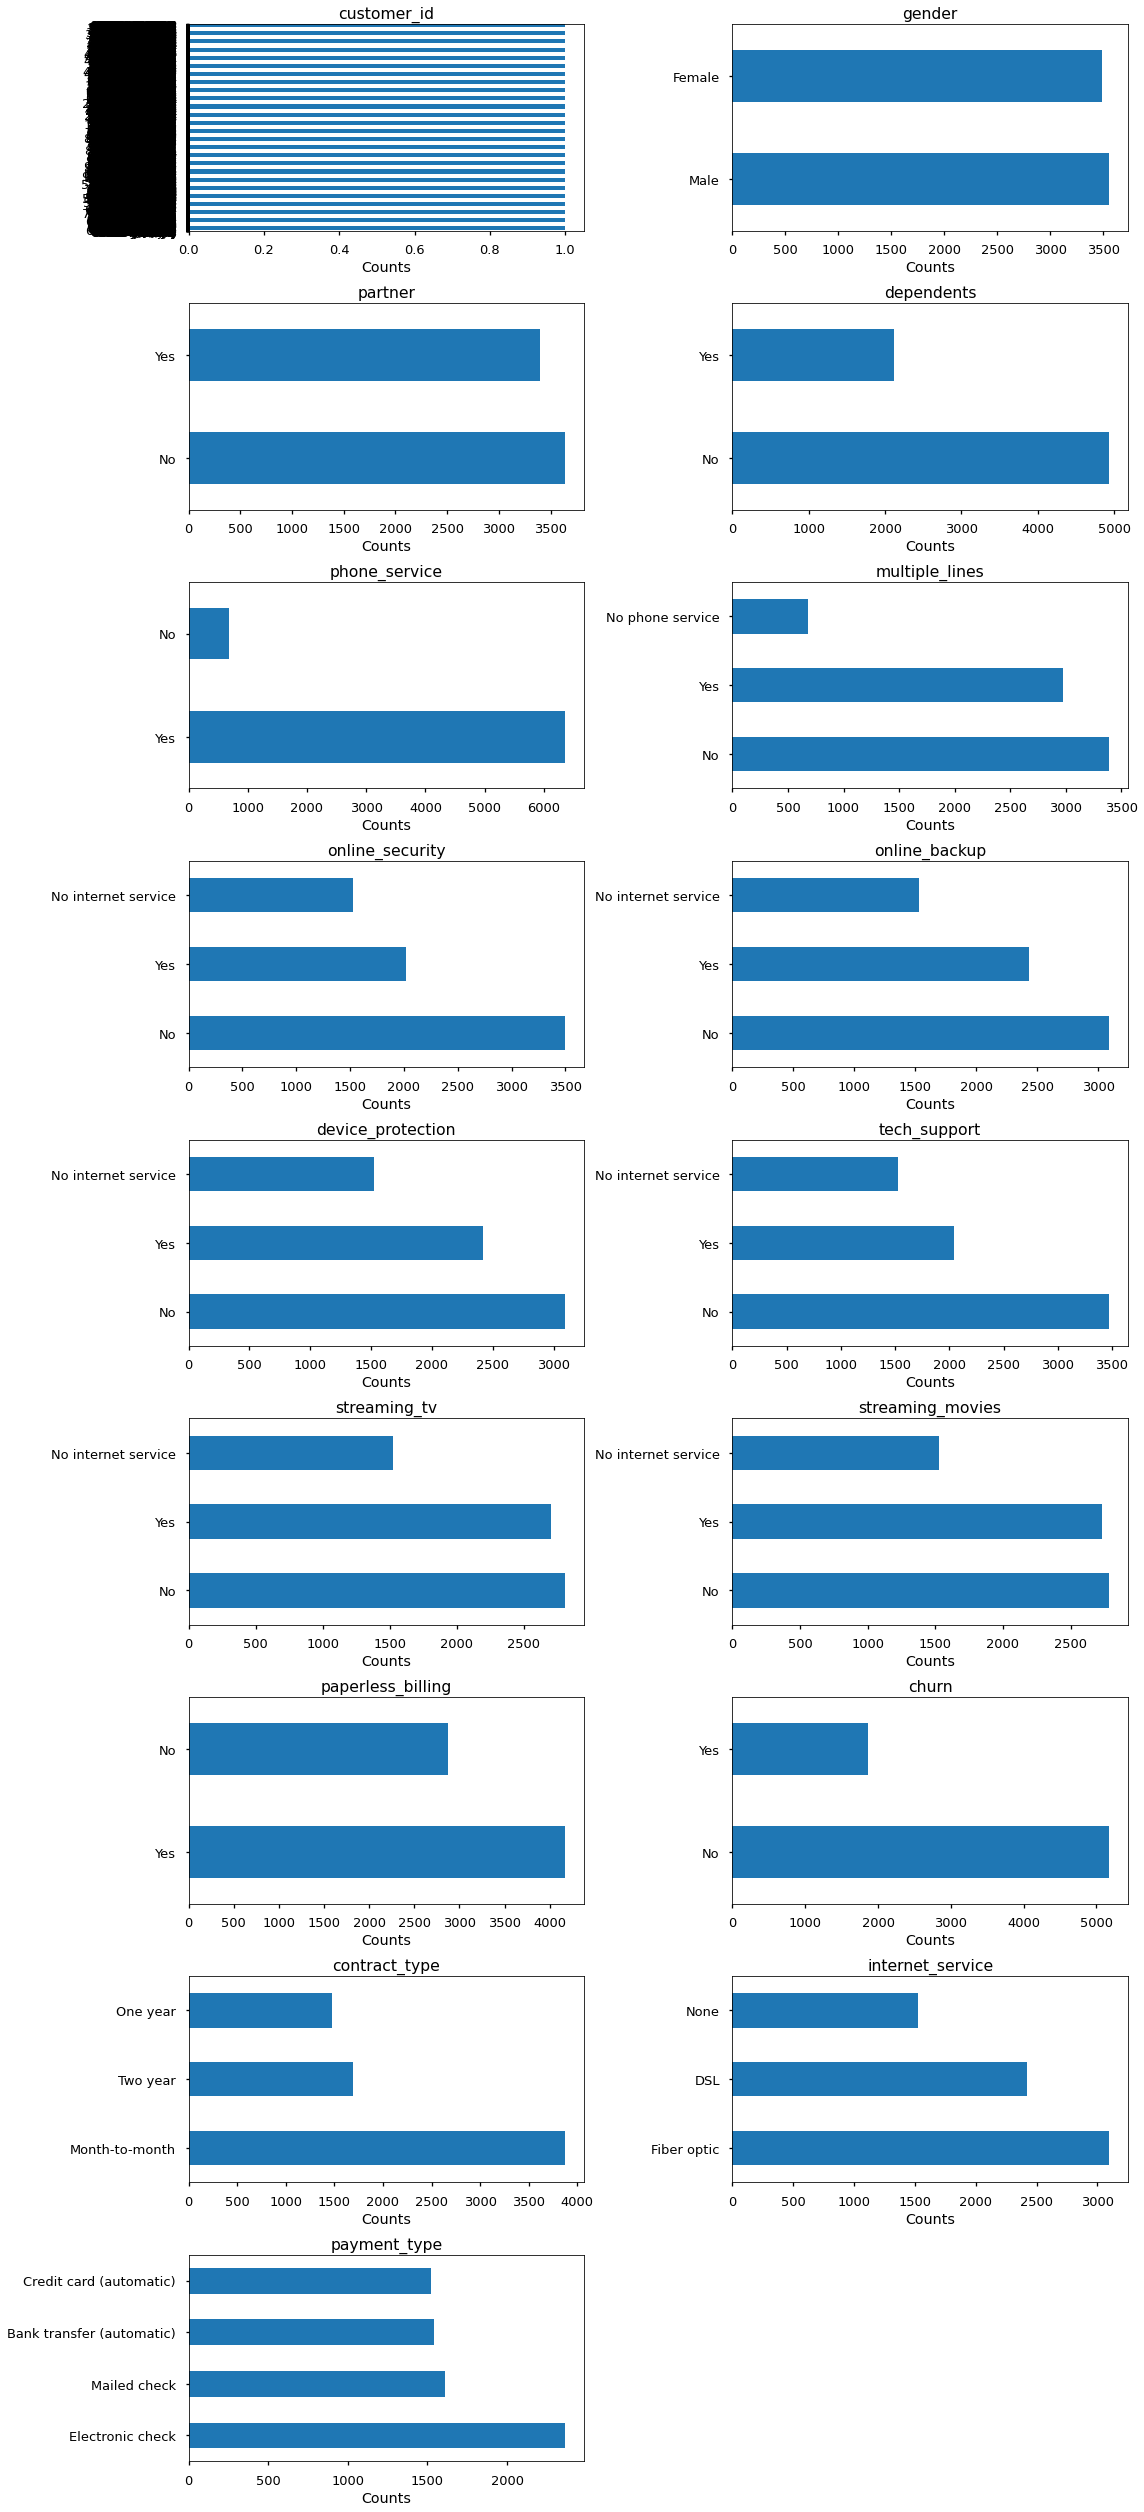

In [10]:

# Plot the histograms of each object column

plt.figure(figsize=(16,35))

number_cols = len(obj_cols)

for i, variable in zip(range(number_cols), obj_cols):
    plt.subplot(9,2,i+1)
    df[variable].value_counts().plot(kind='barh', title=f'{variable}')
    plt.xlabel('Counts')
    
plt.tight_layout()
plt.show()

In [11]:
# Obtain the name of the non-object columns

mask = (df.dtypes != 'object')
num_cols = variables[mask].to_list()

# Manually correct the list

num_cols.remove('payment_type_id')
num_cols.remove('internet_service_type_id')
num_cols.remove('contract_type_id')
num_cols.remove('senior_citizen')

print(len(num_cols))
num_cols

3


['tenure', 'monthly_charges', 'total_charges']

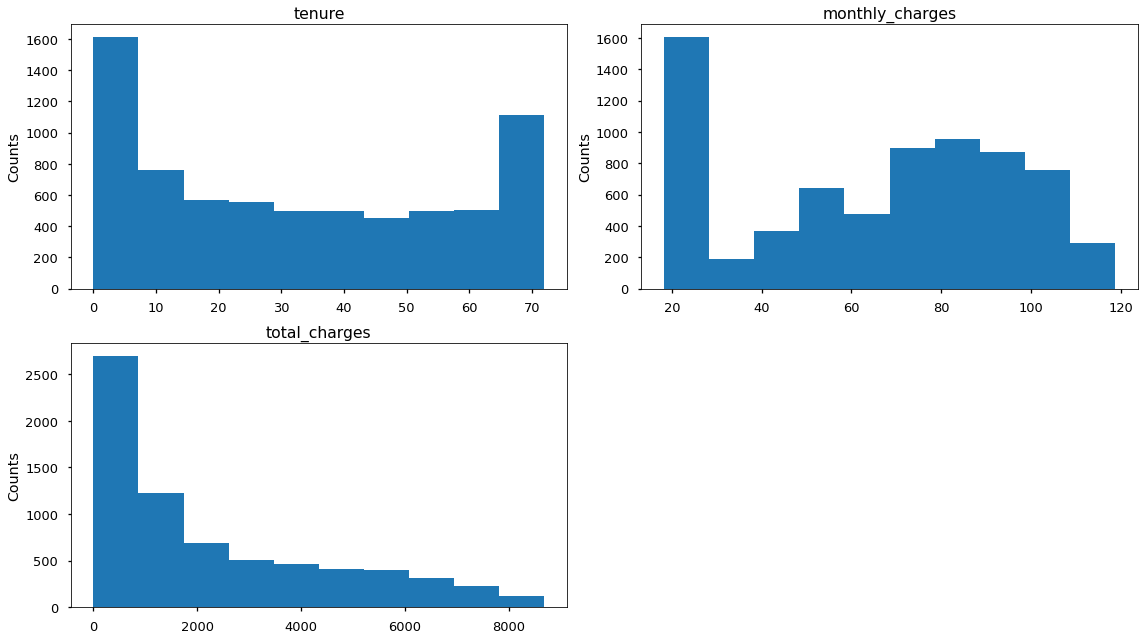

In [12]:
# Plot the histograms of each numeric column

plt.figure(figsize=(16,9))

number_cols = len(num_cols)

for i, variable in zip(range(number_cols), num_cols):
    plt.subplot(2,2,i+1)
    df[variable].plot(kind='hist', title=f'{variable}')
    plt.ylabel("Counts")
    
plt.tight_layout()
plt.show()


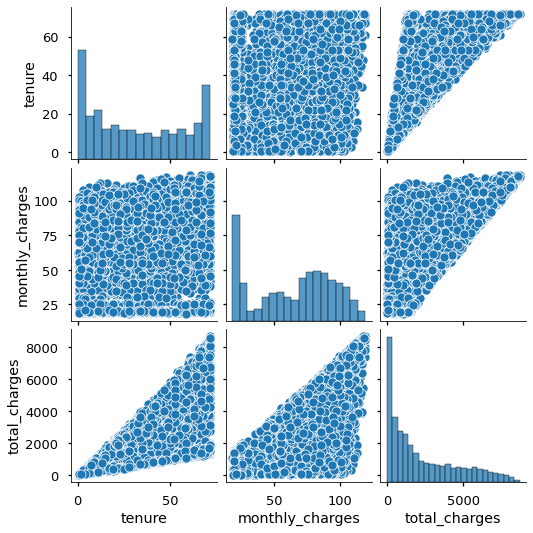

In [13]:
# Pairplot the numeric variables

sns.pairplot(df[num_cols])
plt.show()

In [14]:
# Prepare the data for exploration and modeling

train, validate, test = prepare_2.prep_telco_churn(df)
train.head()

,customer_id,senior_citizen,tenure,phone_service,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service,tenure_year,male
5310,7503-MIOGA,1,72,1,1,1,1,89.85,6697.35,0,2,1,1,1,1,1,6.0,0
3790,5329-KRDTM,1,72,1,1,1,0,77.35,5396.25,0,2,1,1,1,1,1,6.0,1
4398,6199-IWKGC,1,46,1,0,1,0,100.25,4753.85,0,1,1,0,1,1,0,3.8,0
2635,3748-FVMZZ,0,4,0,0,1,1,40.05,162.45,0,0,1,0,0,1,0,0.3,1
2986,4280-DLSHD,0,8,1,1,0,1,54.75,445.85,0,0,1,0,1,0,1,0.7,1


In [15]:
# Print a concise summary of train dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5310 to 6817
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        3943 non-null   object 
 1   senior_citizen     3943 non-null   int64  
 2   tenure             3943 non-null   int64  
 3   phone_service      3943 non-null   int64  
 4   device_protection  3943 non-null   int64  
 5   tech_support       3943 non-null   int64  
 6   paperless_billing  3943 non-null   int64  
 7   monthly_charges    3943 non-null   float64
 8   total_charges      3943 non-null   float64
 9   churn              3943 non-null   int64  
 10  contract_type      3943 non-null   int64  
 11  internet_service   3943 non-null   int64  
 12  payment_type       3943 non-null   int64  
 13  partner_dependent  3943 non-null   int64  
 14  streaming          3943 non-null   int64  
 15  online_service     3943 non-null   int64  
 16  tenure_year        39

In [16]:
# Print the shapes of the train, validate and test

train.shape, validate.shape, test.shape

((3943, 18), (1691, 18), (1409, 18))

### Data Exploration Stage
- Explore the target variable
- What is the churn rate?
- Conduct hypothesis test: 
    - I will be comparing the means of two variables, retained and churned monthly charges, so I will be using a T-test to test my hypothesis.

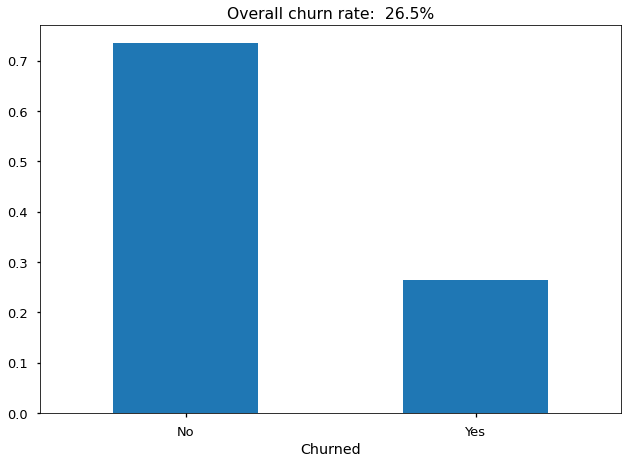

In [17]:
# Compute and visualize the overall churn rate

train.churn.value_counts(normalize=True).plot.bar()
churn_rate = train.churn.mean()
plt.title(f"Overall churn rate: {churn_rate: .1%}")
plt.xlabel('Churned')
plt.xticks([0,1], ['No', 'Yes'], rotation=0) # Set text labels and properties
plt.show()

### Do customers churn because their monthly bill is too expensive?
Null Hypothesis: The monthly bill paid by the churned customers is the same as the customers who stay.

Alternate Hypothesis: Churned customers have a higher monthly bill than the customers who stay.

Alpha =0.05

In [86]:
# Calculate the variances 
train_churned.monthly_charges.var(), train_retained.monthly_charges.var()

# Perform 2 sample t-test
t, p = stats.ttest_ind(train_churned.monthly_charges,
                       train_retained.monthly_charges,
                       equal_var=False)
# print(t, p)

# Decide whether to reject or accept the null hypothesis

if p < 0.5:
    print('Reject Null Hypotheis')
else:
    print('Accept Null Hypotheis')

Reject Null Hypotheis


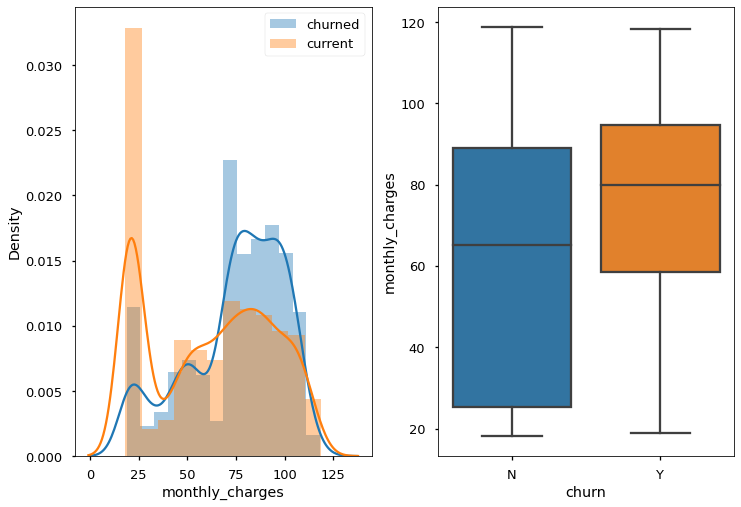

In [85]:
# Plot the distribution of the monthly charges in churned and retained customers
plt.subplot(121)

sns.distplot(train_churned.monthly_charges, label='churned')
sns.distplot(train_retained.monthly_charges, label='current')
plt.legend()

# Draw the box plots to show the distribution
plt.subplot(122)

sns.boxplot(data=train, x='churn', y='monthly_charges')
plt.xticks([0,1], ['N','Y'])

plt.tight_layout()
plt.show()

### Modeling and Evaluation
The algorithms to be tested will be:
- Logistic regression
- Decision tree
- Random forest
- KNN

Accuracy and recall will be used as the performance metrics, especially recall, because because it is better to send a retained customer for review than it is to miss out on an actually churned customer.

In [30]:
# Remove attributes that are either unrelated to the target variable or correlated to other attributes

X_train = train.drop(columns=['customer_id','churn','male','phone_service','total_charges','tenure_year'])
X_validate = validate.drop(columns=['customer_id','churn','male','phone_service','total_charges','tenure_year'])
X_test = test.drop(columns=['customer_id','churn','male','phone_service','total_charges','tenure_year'])

# Create target variable

y_train = train['churn']
y_validate = validate['churn']
y_test = test['churn']

In [31]:
# Inspect the X_train
X_train.tail()

,senior_citizen,tenure,device_protection,tech_support,paperless_billing,monthly_charges,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service
6230,0,72,1,0,1,103.4,2,1,0,1,1,1
356,1,52,1,1,1,50.5,0,1,0,0,1,1
2128,0,41,1,1,1,102.6,1,1,0,1,1,0
3586,0,10,0,1,0,64.9,1,1,0,0,1,1
6817,1,49,1,0,1,88.2,0,1,0,1,0,1


In [32]:
X_train.columns

Index(['senior_citizen', 'tenure', 'device_protection', 'tech_support',
       'paperless_billing', 'monthly_charges', 'contract_type',
       'internet_service', 'payment_type', 'partner_dependent', 'streaming',
       'online_service'],
      dtype='object')

### Baseline Model

In [35]:
# Compute the accuracy of the baseline model
y_train.value_counts(normalize=True)

0    0.73472
1    0.26528
Name: churn, dtype: float64

#### What does this tell us?

- The accuracy of the baseline model is 73.5%

### Logistic Regression

- the goal with this model is to find values for the coefficients that weight each input variable.
- the output is a value between 0 and 1 that represents the probability of one class over the other.
- Much like linear regression, logistic regression works best when you remove attributes that aren't related to the output variable, or attached to other attributes.

In [47]:
# Create the logistic regression object

logit = LogisticRegression()



# Fit the model to the training data
logit.fit(X_train, y_train)


LogisticRegression()

In [48]:
#Evaluate importance, or weight, of each feature, using the coefficients.

#Evaluate the intercept of the model.

# Rank features by the absolute values of their coefficient

coefficient = logit.coef_
coefficient = pd.DataFrame(coefficient).T
coefficient['features'] = X_train.columns.tolist()
coefficient['coefficient_abs'] = coefficient[0].abs()
coefficient.sort_values(by='coefficient_abs', ascending=False)

,0,features,coefficient_abs
6,-0.744044,contract_type,0.744044
7,0.573914,internet_service,0.573914
11,-0.492695,online_service,0.492695
4,0.422379,paperless_billing,0.422379
3,-0.405454,tech_support,0.405454
8,-0.315344,payment_type,0.315344
0,0.284009,senior_citizen,0.284009
9,-0.116382,partner_dependent,0.116382
2,-0.093053,device_protection,0.093053
10,-0.035030,streaming,0.035030


In [49]:
# Evaluate accuracy and recall using train dataset
# Estimate the probability

train_acc = logit.score(X_train, y_train)
print(train_acc, "\n")

y_pred_train = logit.predict(X_train)
print(classification_report(y_train, y_pred_train), '\n')

0.7963479584073041 

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.65      0.51      0.57      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.71      0.72      3943
weighted avg       0.79      0.80      0.79      3943
 



In [50]:
# Compute the accuracy
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))


Accuracy of Logistic Regression classifier on training set: 0.80


In [51]:
# Create a confusion matrix
print(confusion_matrix(y_train, y_pred))

[[ 239 2658]
 [   1 1045]]


In [52]:
# Create a classification Report
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.08      0.15      2897
           1       0.28      1.00      0.44      1046

    accuracy                           0.33      3943
   macro avg       0.64      0.54      0.30      3943
weighted avg       0.81      0.33      0.23      3943



### Decision Trees
aka CART: Classification and Regression Trees
- We use the training data to train the tree to find a decision boundary to use as a decision rule for future data
- Sorta like playing 20 questions. Each question is a yes or a no. The number of questions is the depth of the tree.
- Give too much depth and you risk overfitting your model.

In [53]:
# Create the Deicsion Tree object
dt = DecisionTreeClassifier(max_depth=3, random_state=123)

In [54]:
# Fit the model
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [55]:
# Get the parameters of the model
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

In [56]:
# Print the Gini importances

importances = dt.feature_importances_
importances = pd.DataFrame(importances, index=X_train.columns, columns=['total_reduction'])
importances

,total_reduction
senior_citizen,0.000000
tenure,0.218841
device_protection,0.000000
tech_support,0.000000
paperless_billing,0.000000
monthly_charges,0.168075
contract_type,0.613084
internet_service,0.000000
payment_type,0.000000
partner_dependent,0.000000


In [57]:
# Evaluate accuracy and recall using train dataset

train_acc = dt.score(X_train, y_train)
print(train_acc, "\n")

y_pred_train = dt.predict(X_train)
print(classification_report(y_train, y_pred_train), '\n')

# Print the confusion matrix
matrix = confusion_matrix(y_train, y_pred_train)
matrix

0.7851889424296221 

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      2897
           1       0.68      0.36      0.47      1046

    accuracy                           0.79      3943
   macro avg       0.74      0.65      0.67      3943
weighted avg       0.77      0.79      0.76      3943
 



array([[2715,  182],
       [ 665,  381]])

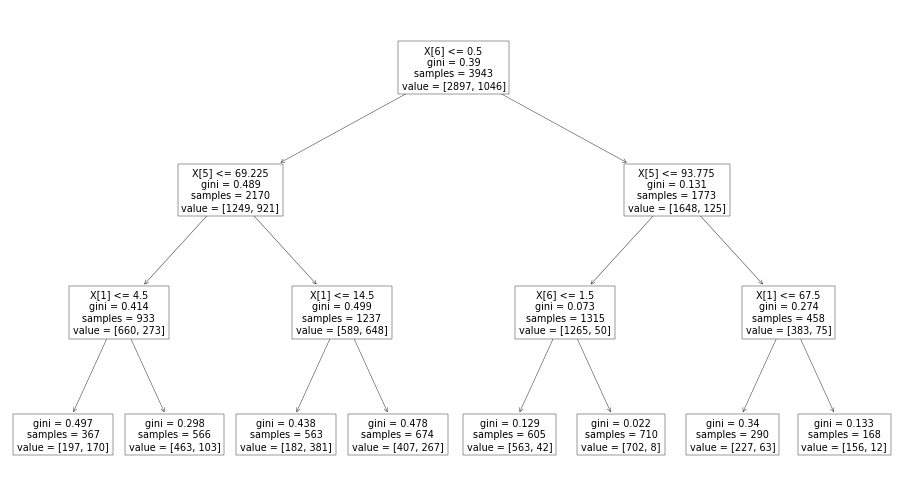

In [58]:
# Visualize the tree structure

plt.figure(figsize=(16,9))
plot_tree(dt)
plt.show()

### Random Forest 

- Random Forest is a type Ensemble Machine Learning algorithm called Bootstrap Aggregation or bagging.
- Bootstrapping is a statistical method for estimating a quantity from a data sample, e.g. mean. 
- Multiple samples of your training data are taken and models are constructed for each sample set. 
- Random forest is a tweak on this approach where decision trees are created so that rather than selecting optimal split points, suboptimal splits are made by introducing randomness.


In [59]:
# Create the random forest object

rf = RandomForestClassifier(n_estimators=100, 
                            max_depth=3, 
                            min_samples_split=2, 
                            min_samples_leaf=5, 
                            random_state=123)

In [60]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [61]:
# Evaluate importance

importances = rf.feature_importances_
importances = pd.DataFrame(importances, index=X_train.columns, columns=['total_reduction'])
importances

,total_reduction
senior_citizen,0.008060
tenure,0.232600
device_protection,0.003057
tech_support,0.040041
paperless_billing,0.037450
monthly_charges,0.105619
contract_type,0.362070
internet_service,0.087600
payment_type,0.052770
partner_dependent,0.020144


In [62]:
# Make predictions

y_pred = rf.predict(X_train)

In [63]:
# Estimate Probability

y_pred_proba = rf.predict_proba(X_train)

In [64]:
# Compute the Accuracy

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.78


In [65]:
# Create a classfication report

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      2897
           1       0.74      0.27      0.39      1046

    accuracy                           0.78      3943
   macro avg       0.76      0.62      0.63      3943
weighted avg       0.77      0.78      0.74      3943



In [66]:
# Create a confusion matrix

print(confusion_matrix(y_train, y_pred))

[[2801   96]
 [ 768  278]]


In [67]:
# Evaluate on Out-of-Sample data

print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.77


### KNN

- Makes predictions based on how close a new data point is to known data points.
- Considered a lazy algorithm in that it does not attempt to construct a general internal model, but simply stores instances of the training data.
- Predictions are made for a new data point by searching through the entire training set for the K most similar instances (the neighbors) and summarizing the output variable for those K instances.
- For classification problems this might be the mode (or most common) class value.

In [68]:
# Create KNN Object

# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [69]:
# Fit the model

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [70]:
# Make predictions

y_pred = knn.predict(X_train)

In [71]:
# Estimate probability

y_pred_proba = knn.predict_proba(X_train)

In [72]:
# Compute accuracy of model

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.83


In [73]:
# Create a confusion matrix

print(confusion_matrix(y_train, y_pred))

[[2648  249]
 [ 405  641]]


In [74]:
# Create a classification report

print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2897
           1       0.72      0.61      0.66      1046

    accuracy                           0.83      3943
   macro avg       0.79      0.76      0.78      3943
weighted avg       0.83      0.83      0.83      3943



In [75]:
# Lets validate our model 

print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.76


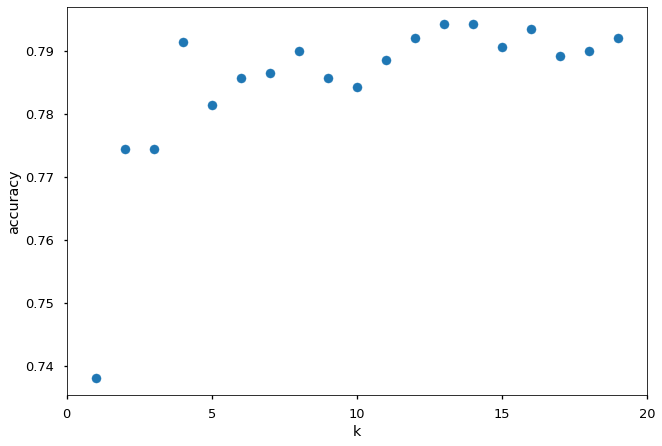

In [76]:
# Visualize model

import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

In [77]:
# Summary

# Create a list of names of the classifiers

names = ['LogisticRegression', 
         'Decision Tree',
         'Random Forest',
         'K-Nearest Neighbors'
        ]

# Create a list of classifiers

classifiers = [LogisticRegression(), 
               DecisionTreeClassifier(max_depth=3, random_state=123),
               RandomForestClassifier(max_depth=3, random_state=123),
               KNeighborsClassifier(5)
              ]

# Create a dataframe to hold the results
performance = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    
    clf = classifier.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    
    y_pred_validate = clf.predict(X_validate)
    validate_acc = accuracy_score(y_validate, y_pred_validate)
    validate_recall = recall_score(y_validate, y_pred_validate)
    
    d = {'model': name,
         'train_acc': train_acc, 'train_recall': train_recall,
         'validate_acc': validate_acc, 'validate_recall': validate_recall}
    
    performance = performance.append(d, ignore_index=True)
    
performance

,model,train_acc,train_recall,validate_acc,validate_recall
0,LogisticRegression,0.796348,0.513384,0.801892,0.518931
1,Decision Tree,0.785189,0.364245,0.785334,0.367483
2,Random Forest,0.784174,0.279159,0.775281,0.249443
3,K-Nearest Neighbors,0.834136,0.612811,0.760497,0.485523


### Summary

- Logistic Regression is selected to be the best model for further testing because both its accuracy and recall rank high and it doesn't appear to have an overfitting problem.
- The recalls of decision tree and random forest aren't good.
- KNN is not selected due to overfitting.

### Testing the best model

In [80]:

# Evaluate accuracy and precision using validate dataset

test_acc = logit.score(X_test, y_test)
print(test_acc, "\n")

y_pred_test = logit.predict(X_test)
print(classification_report(y_test, y_pred_test), '\n')

# Print the confusion matrix
matrix = confusion_matrix(y_test, y_pred_test)

matrix



0.8126330731014905 

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1035
           1       0.68      0.55      0.61       374

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409
 



array([[940,  95],
       [169, 205]])

#### Summary
- Logisitic Regression does well on the test datasets.
- Has an accuracy of 81% with a precision of 85%

#### Top Three Drivers
Because logistic regression has been tested to be the best model, the coefficient of the features is used to pick the top five drivers.

In [81]:
# Print the top 3 features with highest absolute value of coefficient
coefficient.sort_values(by='coefficient_abs', ascending=False).head(3)

,0,features,coefficient_abs
6,-0.744044,contract_type,0.744044
7,0.573914,internet_service,0.573914
11,-0.492695,online_service,0.492695


### In Conclusion
- The main drivers of churn are contract type, type of internet service, and online service.
- Logisitic Regression for the win. It is top model.

### What's Next?
- Explore the reasons behind why contract type, internet type, and online service affect the consumer base.
- Optimize the classification model by combining different variables and changeing hyperparameters.